In [2]:
from sqlalchemy import create_engine, MetaData, Table, inspect
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.stats as stats

In [3]:
def new_engine(dialect, server, database, user=None, password=None, integrated_security=True):
    if integrated_security:
        # For Windows authentication
        eng = f"{dialect}://{server}/{database}?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server"
    else:
        # For SQL Server authentication
        eng = f"{dialect}://{user}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server"
    print(eng)
    return create_engine(eng)

In [4]:
dialect = "mssql"
servern = "DESKTOP-BJG883B"
database = 'AdventureWorks2022'

engine = new_engine(dialect, servern, database)
connection = engine.connect()
inspector = inspect(engine)


mssql://DESKTOP-BJG883B/AdventureWorks2022?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server


In [5]:
inspector = inspect(engine)
schemas = inspector.get_schema_names()
print(schemas)
schemas = schemas[11:-1] # för vi vill bara ha alla våra relevanta schemas.
del schemas[1]# vi vill heller inte ha 'INFORMATION_SCHEMA'
print(schemas)

['db_accessadmin', 'db_backupoperator', 'db_datareader', 'db_datawriter', 'db_ddladmin', 'db_denydatareader', 'db_denydatawriter', 'db_owner', 'db_securityadmin', 'dbo', 'guest', 'HumanResources', 'INFORMATION_SCHEMA', 'Person', 'Production', 'Purchasing', 'Sales', 'sys']
['HumanResources', 'Person', 'Production', 'Purchasing', 'Sales']


In [6]:
tables = []
for i in range(len(schemas)):
    tables.append(inspector.get_table_names(schema=schemas[i]))

listschemas_tables = []
for i in range(len(tables)):
    listschemas_tables.append(len(tables[i]))
    
dfschemas_tables = pd.DataFrame(index=schemas,data = listschemas_tables,columns = ["tables"])
dfschemas_tables

,tables
HumanResources,6
Person,14
Production,25
Purchasing,5
Sales,19


In [7]:
columns = []

for j in range(len(tables)):
    temp = []
    for k in range(len(tables[j])):
        names = []
        for i in inspector.get_columns(table_name=tables[j][k], schema=schemas[j]):
            names.append(i['name'])
        temp.append(names)
    columns.append(temp)

#obs denna erroren kommer ibland osäker på varför

C:\Users\serig\AppData\Local\Temp\ipykernel_24364\299870870.py:7: SAWarning: Did not recognize type 'hierarchyid' of column 'OrganizationNode'
  for i in inspector.get_columns(table_name=tables[j][k], schema=schemas[j]):
C:\Users\serig\AppData\Local\Temp\ipykernel_24364\299870870.py:7: SAWarning: Did not recognize type 'geography' of column 'SpatialLocation'
  for i in inspector.get_columns(table_name=tables[j][k], schema=schemas[j]):
C:\Users\serig\AppData\Local\Temp\ipykernel_24364\299870870.py:7: SAWarning: Did not recognize type 'hierarchyid' of column 'DocumentNode'
  for i in inspector.get_columns(table_name=tables[j][k], schema=schemas[j]):


In [8]:
print(schemas[1])#alla scheman
print(tables[1][0])#[schema id],[tabel id]
print(columns[1][0])#[schema id],[tabel id],[columns id]
print(len(columns[1][0]))#antal columner i tabell
print(schemas[3],".",tables[3][0],".",columns[3][0][1])# ex schema.table.columnid

Person
Address
['AddressID', 'AddressLine1', 'AddressLine2', 'City', 'StateProvinceID', 'PostalCode', 'SpatialLocation', 'rowguid', 'ModifiedDate']
9
Purchasing . ProductVendor . BusinessEntityID


In [9]:
Products = """SELECT * FROM Production.ProductCategory"""
dfProducts = pd.read_sql(sql=Products, con=connection)
dfProducts

,ProductCategoryID,Name,rowguid,ModifiedDate
0,1,Bikes,CFBDA25C-DF71-47A7-B81B-64EE161AA37C,2008-04-30
1,2,Components,C657828D-D808-4ABA-91A3-AF2CE02300E9,2008-04-30
2,3,Clothing,10A7C342-CA82-48D4-8A38-46A2EB089B74,2008-04-30
3,4,Accessories,2BE3BE36-D9A2-4EEE-B593-ED895D97C2A6,2008-04-30


In [10]:
# extremt redundan kod för att se allt som finns i hela databasen, 
#men genom att söka via queries så kan vi söka efter liknande columner
#fokus på försjälning och kunder
searchword = "CustomerID"
columnsearch = """
	SELECT A.name as ColumnName, ----a.name variable columnnamn "ColumnName"
		(SCHEMA_NAME(B.schema_id) + '.' + B.name) AS 'TableName'--schema_name returns sysname för (b.schema_id) + b.namn)) as columnamn, bygger string basicly
	FROM  sys.columns as A INNER JOIN sys.tables as B
		on A.object_id = B.object_id --- joinar tables som innehåller businessEntityID
	WHERE A.name LIKE '%"""+searchword+"""%'
	ORDER BY TableName, ColumnName;
"""

In [11]:
tempsearch = pd.read_sql(sql=columnsearch, con=connection)
salesorderh = """SELECT * FROM Sales.SalesOrderHeader"""
dfsalesorder = pd.read_sql(sql=salesorderh, con=connection)

In [12]:
tempsearch

,ColumnName,TableName
0,CustomerID,Sales.Customer
1,CustomerID,Sales.SalesOrderHeader


In [13]:
dfsalesorder # visar inte alla columner
pd.set_option('display.max_columns', None)
dfsalesorder

,SalesOrderID,RevisionNumber,OrderDate,DueDate,ShipDate,Status,OnlineOrderFlag,SalesOrderNumber,PurchaseOrderNumber,AccountNumber,CustomerID,SalesPersonID,TerritoryID,BillToAddressID,ShipToAddressID,ShipMethodID,CreditCardID,CreditCardApprovalCode,CurrencyRateID,SubTotal,TaxAmt,Freight,TotalDue,Comment,rowguid,ModifiedDate
0,43659,8,2011-05-31,2011-06-12,2011-06-07,5,False,SO43659,PO522145787,10-4020-000676,29825,279.0,5,985,985,5,16281.0,105041Vi84182,NaN,20565.6206,1971.5149,616.0984,23153.2339,None,79B65321-39CA-4115-9CBA-8FE0903E12E6,2011-06-07
1,43660,8,2011-05-31,2011-06-12,2011-06-07,5,False,SO43660,PO18850127500,10-4020-000117,29672,279.0,5,921,921,5,5618.0,115213Vi29411,NaN,1294.2529,124.2483,38.8276,1457.3288,None,738DC42D-D03B-48A1-9822-F95A67EA7389,2011-06-07
2,43661,8,2011-05-31,2011-06-12,2011-06-07,5,False,SO43661,PO18473189620,10-4020-000442,29734,282.0,6,517,517,5,1346.0,85274Vi6854,4.0,32726.4786,3153.7696,985.5530,36865.8012,None,D91B9131-18A4-4A11-BC3A-90B6F53E9D74,2011-06-07
3,43662,8,2011-05-31,2011-06-12,2011-06-07,5,False,SO43662,PO18444174044,10-4020-000227,29994,282.0,6,482,482,5,10456.0,125295Vi53935,4.0,28832.5289,2775.1646,867.2389,32474.9324,None,4A1ECFC0-CC3A-4740-B028-1C50BB48711C,2011-06-07
4,43663,8,2011-05-31,2011-06-12,2011-06-07,5,False,SO43663,PO18009186470,10-4020-000510,29565,276.0,4,1073,1073,5,4322.0,45303Vi22691,NaN,419.4589,40.2681,12.5838,472.3108,None,9B1E7A40-6AE0-4AD3-811C-A64951857C4B,2011-06-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31460,75119,8,2014-06-30,2014-07-12,2014-07-07,5,True,SO75119,None,10-4030-011981,11981,NaN,1,17649,17649,1,6761.0,429826Vi35166,NaN,42.2800,3.3824,1.0570,46.7194,None,9382F1C9-383A-435F-9449-0EECEA21B78D,2014-07-07
31461,75120,8,2014-06-30,2014-07-12,2014-07-07,5,True,SO75120,None,10-4030-018749,18749,NaN,6,28374,28374,1,8925.0,929849Vi46003,NaN,84.9600,6.7968,2.1240,93.8808,None,AE6A4FCF-FF73-4CD4-AF2C-5993D00D4AFE,2014-07-07
31462,75121,8,2014-06-30,2014-07-12,2014-07-07,5,True,SO75121,None,10-4030-015251,15251,NaN,6,26553,26553,1,14220.0,529864Vi73738,NaN,74.9800,5.9984,1.8745,82.8529,None,D7395C0E-00CB-4BFA-A238-0D6A9F49884F,2014-07-07
31463,75122,8,2014-06-30,2014-07-12,2014-07-07,5,True,SO75122,None,10-4030-015868,15868,NaN,6,14616,14616,1,18719.0,330022Vi97312,NaN,30.9700,2.4776,0.7743,34.2219,None,4221035A-4159-492F-AF40-4363A64FFC16,2014-07-07


In [14]:
compremeradsalesorder = """SELECT 
	SalesOrderID
	,CustomerID
	,SalesPersonID
	,SubTotal
	,TaxAmt
	,Freight
	,TotalDue
	,DueDate
FROM Sales.SalesOrderHeader"""
dfcompremeradsalesorder = pd.read_sql(sql=compremeradsalesorder, con=connection)
dfcompremeradsalesorder

,SalesOrderID,CustomerID,SalesPersonID,SubTotal,TaxAmt,Freight,TotalDue,DueDate
0,43659,29825,279.0,20565.6206,1971.5149,616.0984,23153.2339,2011-06-12
1,43660,29672,279.0,1294.2529,124.2483,38.8276,1457.3288,2011-06-12
2,43661,29734,282.0,32726.4786,3153.7696,985.5530,36865.8012,2011-06-12
3,43662,29994,282.0,28832.5289,2775.1646,867.2389,32474.9324,2011-06-12
4,43663,29565,276.0,419.4589,40.2681,12.5838,472.3108,2011-06-12
...,...,...,...,...,...,...,...,...
31460,75119,11981,NaN,42.2800,3.3824,1.0570,46.7194,2014-07-12
31461,75120,18749,NaN,84.9600,6.7968,2.1240,93.8808,2014-07-12
31462,75121,15251,NaN,74.9800,5.9984,1.8745,82.8529,2014-07-12
31463,75122,15868,NaN,30.9700,2.4776,0.7743,34.2219,2014-07-12


In [15]:
salescustomerid = """SELECT 
	CustomerID
	,PersonID
	,StoreID
FROM Sales.Customer"""
dfsalescustomerid = pd.read_sql(sql=salescustomerid, con=connection)
dfsalescustomerid #personid är pri key till businessentityID och storeid till sales.store

,CustomerID,PersonID,StoreID
0,1,NaN,934.0
1,2,NaN,1028.0
2,3,NaN,642.0
3,4,NaN,932.0
4,5,NaN,1026.0
...,...,...,...
19815,30114,1985.0,1986.0
19816,30115,1987.0,1988.0
19817,30116,1989.0,1990.0
19818,30117,1991.0,1992.0


In [16]:
def searchword (sökord):
    searchword = sökord
    columnsearch = """
        SELECT A.name as ColumnName, ----a.name variable columnnamn "ColumnName"
        (SCHEMA_NAME(B.schema_id) + '.' + B.name) AS 'TableName'--schema_name returns sysname för (b.schema_id) + b.namn)) as columnamn, bygger string basicly
        FROM  sys.columns as A INNER JOIN sys.tables as B
        on A.object_id = B.object_id --- joinar tables som innehåller businessEntityID
        WHERE A.name LIKE '%"""+searchword+"""%'
        ORDER BY TableName, ColumnName;
    """
    return columnsearch 
#gjorde en snabb funktion för repeterat arbete

In [17]:
searchword1 = searchword("BusinessEntityid") 
searchword2 = searchword("StoreID") 
# alla store id har ett person id, obs alla person id har inte en store id, indivduella kunder
# store ör jömna och person id är storeid+1 som hänvisar till kontaktperson till affär
dfsearchword1 = pd.read_sql(sql=searchword1, con=connection)
dfsearchword2 = pd.read_sql(sql=searchword2, con=connection)

In [18]:
dfsearchword1

,ColumnName,TableName
0,BusinessEntityID,HumanResources.Employee
1,BusinessEntityID,HumanResources.EmployeeDepartmentHistory
2,BusinessEntityID,HumanResources.EmployeePayHistory
3,BusinessEntityID,HumanResources.JobCandidate
4,BusinessEntityID,Person.BusinessEntity
5,BusinessEntityID,Person.BusinessEntityAddress
6,BusinessEntityID,Person.BusinessEntityContact
7,BusinessEntityID,Person.EmailAddress
8,BusinessEntityID,Person.Password
9,BusinessEntityID,Person.Person


In [19]:
dfsearchword2 #kul i vilket fall som helst under description för columne storeID i sql får vi reda på att
#Store ID är FK till store.businessentityid så om vi kollar ovanför så har vi BEID i en column som handlar om sales.store

,ColumnName,TableName
0,StoreID,Sales.Customer


In [20]:
salesstore = """SELECT * FROM Sales.store"""
dfsalesstore = pd.read_sql(sql=salesstore, con=connection) 
print(schemas[4],tables[4][18],columns[4][18][0])
dfsalesstore # innehåller beid som kopplas till storeid och en salesperson som kopplas till beid i person.person


Sales Store BusinessEntityID


,BusinessEntityID,Name,SalesPersonID,Demographics,rowguid,ModifiedDate
0,292,Next-Door Bike Store,279,"<StoreSurvey xmlns=""http://schemas.microsoft.c...",A22517E3-848D-4EBE-B9D9-7437F3432304,2014-09-12 11:15:07.497
1,294,Professional Sales and Service,276,"<StoreSurvey xmlns=""http://schemas.microsoft.c...",B50CA50B-C601-4A13-B07E-2C63862D71B4,2014-09-12 11:15:07.497
2,296,Riders Company,277,"<StoreSurvey xmlns=""http://schemas.microsoft.c...",337C3688-1339-4E1A-A08A-B54B23566E49,2014-09-12 11:15:07.497
3,298,The Bike Mechanics,275,"<StoreSurvey xmlns=""http://schemas.microsoft.c...",7894F278-F0C8-4D16-BD75-213FDBF13023,2014-09-12 11:15:07.497
4,300,Nationwide Supply,286,"<StoreSurvey xmlns=""http://schemas.microsoft.c...",C3FC9705-A8C4-4F3A-9550-EB2FA4B7B64D,2014-09-12 11:15:07.497
...,...,...,...,...,...,...
696,1988,Retreat Inn,282,"<StoreSurvey xmlns=""http://schemas.microsoft.c...",EA21EC81-1BFA-4A07-9B4D-73D9852AFCBF,2014-09-12 11:15:07.497
697,1990,Technical Parts Manufacturing,281,"<StoreSurvey xmlns=""http://schemas.microsoft.c...",C8E3C4ED-8F58-4DB2-B600-E0CD11D9CFAD,2014-09-12 11:15:07.497
698,1992,Totes & Baskets Company,277,"<StoreSurvey xmlns=""http://schemas.microsoft.c...",CE860B58-643C-4567-BFD8-06E97969CC67,2014-09-12 11:15:07.497
699,1994,World of Bikes,277,"<StoreSurvey xmlns=""http://schemas.microsoft.c...",0C10F2B6-A13A-440C-9C25-5B28D482872A,2014-09-12 11:15:07.497


In [21]:
Personperson = """SELECT * FROM Person.Person"""
dfpersonperson = pd.read_sql(sql=Personperson, con=connection) 
dfpersonperson

,BusinessEntityID,PersonType,NameStyle,Title,FirstName,MiddleName,LastName,Suffix,EmailPromotion,AdditionalContactInfo,Demographics,rowguid,ModifiedDate
0,1,EM,False,None,Ken,J,Sánchez,None,0,None,"<IndividualSurvey xmlns=""http://schemas.micros...",92C4279F-1207-48A3-8448-4636514EB7E2,2009-01-07
1,2,EM,False,None,Terri,Lee,Duffy,None,1,None,"<IndividualSurvey xmlns=""http://schemas.micros...",D8763459-8AA8-47CC-AFF7-C9079AF79033,2008-01-24
2,3,EM,False,None,Roberto,None,Tamburello,None,0,None,"<IndividualSurvey xmlns=""http://schemas.micros...",E1A2555E-0828-434B-A33B-6F38136A37DE,2007-11-04
3,4,EM,False,None,Rob,None,Walters,None,0,None,"<IndividualSurvey xmlns=""http://schemas.micros...",F2D7CE06-38B3-4357-805B-F4B6B71C01FF,2007-11-28
4,5,EM,False,Ms.,Gail,A,Erickson,None,0,None,"<IndividualSurvey xmlns=""http://schemas.micros...",F3A3F6B4-AE3B-430C-A754-9F2231BA6FEF,2007-12-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19967,20773,IN,False,None,Crystal,None,Guo,None,0,None,"<IndividualSurvey xmlns=""http://schemas.micros...",D0A499A2-C258-43E9-AB06-F61543A71134,2014-03-19
19968,20774,IN,False,None,Isabella,F,Richardson,None,2,None,"<IndividualSurvey xmlns=""http://schemas.micros...",A4F7F248-82F3-43D5-B5A3-8BD1CB610254,2013-07-29
19969,20775,IN,False,None,Crystal,S,He,None,0,None,"<IndividualSurvey xmlns=""http://schemas.micros...",CD0B82D0-3409-4497-A65F-A68E75EE26CB,2014-03-12
19970,20776,IN,False,None,Crystal,None,Zheng,None,1,None,"<IndividualSurvey xmlns=""http://schemas.micros...",386E35E8-97B3-43E4-9B5F-9594C2FF5CEA,2014-01-14


Text(0.5, 1.0, 'PersonType distrubering')

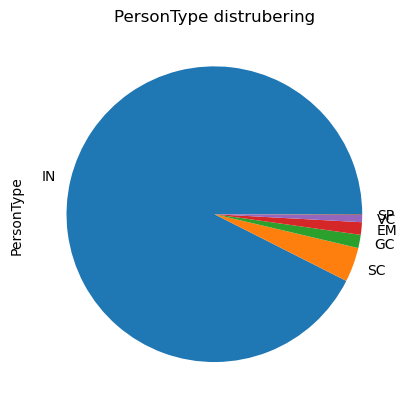

In [22]:
#koncentrera på person type och id
Persondata="""SELECT 
        BusinessEntityID
        ,PersonType
    FROM Person.Person"""
dfpersondata = pd.read_sql(sql=Persondata, con=connection)
dfpersondata.PersonType.value_counts().plot(kind='pie')
plt.title('PersonType distrubering')
#Primary type of person:
# SC = Store Contact,
# IN = Individual (retail) customer,
# SP = Sales person,
# EM = Employee (non-sales),
# VC = Vendor contact,
# GC = General contact
# info finns i column description is sql, inte hittat hur man får den info via sqlachlemy

In [23]:
dfpersondata["PersonType"].value_counts() #stor andel Individual customers, 

IN    18484
SC      753
GC      289
EM      273
VC      156
SP       17
Name: PersonType, dtype: int64

Text(0.5, 1.0, 'PersonType distrubering. dropped IN,SC')

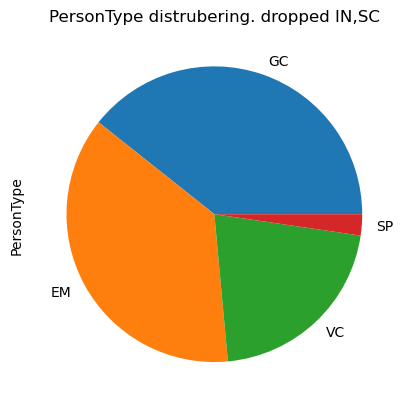

In [25]:
Persontype = dfpersondata.PersonType.value_counts()
Persontype.drop(["IN","SC"]).plot(kind='pie')
plt.title('PersonType distrubering. dropped IN,SC')

In [26]:
Persontype.drop(["IN","SC"]).sum()

735

Text(0.5, 1.0, 'PersonType distrubering')

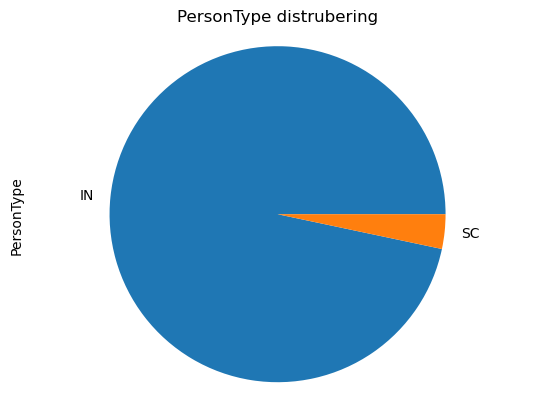

In [27]:
köpdata = """SELECT 
        a.CustomerID
        ,sum(a.SubTotal) as total
        ,count(a.SalesOrderID) AS [Amount of orders]
        ,MAX(a.ModifiedDate) AS [Last Date]
        ,MIN(a.ModifiedDate) AS [First Date]
        ,datediff(DAY, MIN(a.ModifiedDate), MAX(a.ModifiedDate)) / COUNT(a.SalesOrderID) AS 'Days between orders'
        ,datediff(DAY, MIN(a.ModifiedDate), MAX(a.ModifiedDate)) AS [Total days from F/L date]
        ,sum(a.SubTotal)/count(a.SalesOrderID) AS AVGsubtotaloforders
        ,b.FirstName 
        ,b.LastName
        ,b.PersonType
        ,c.PersonID
        ,c.StoreID
        ,d.Name
        ,d.SalesPersonID
        ,d.FirstName as [SP First name]
        ,d.LastName as [SP Last name]
    FROM Sales.SalesOrderHeader as a
        LEFT JOIN (
            SELECT CustomerID
                    ,PersonID
                    ,StoreID
        FROM Sales.Customer
        ) as c 
            on a.CustomerID = c.CustomerID
        LEFT JOIN (
            SELECT 
            a.BusinessEntityID
            ,a.Name
            ,a.SalesPersonID
            ,b.FirstName 
            ,b.LastName
            ,b.PersonType
        FROM Sales.store as a
            inner join Person.Person as b
                on a.SalesPersonID = b.BusinessEntityID
        ) as d on c.StoreID = d.BusinessEntityID
            LEFT JOIN (
            SELECT FirstName 
            ,LastName
            ,PersonType
            ,BusinessEntityID
        FROM Person.Person
        ) as b
            on c.PersonID = b.BusinessEntityID
    Group BY a.CustomerID ,b.FirstName ,b.LastName ,b.PersonType,c.PersonID,c.StoreID, d.Name, d.SalesPersonID, d.FirstName, d.LastName
    Order by Total DESC"""

#Kortförklaring på vad det är som händer här är att vi tar SalesOrderHeader och leftjoinar 3 andra tabeller med information
#vi lägger till personID/storeID för att sedan lägga till information om den induviduella kunden eller affärs kundens information
#vi använder left join för att vå med null resultat på dem som inte äger en affär osv
dfköpdata  = pd.read_sql(sql=köpdata, con=connection)
dfköpdata.PersonType.value_counts().plot(kind='pie')
plt.axis('equal')
plt.title('PersonType distrubering')

In [28]:
#våra kunder är SC = store contact "butiks ägare", och IN = induvidail retailer "vanliga kunder"
print(dfköpdata.PersonType.value_counts().iloc[0]/dfköpdata.PersonType.value_counts().sum())
print(dfköpdata.PersonType.value_counts().sum())
print(dfköpdata.PersonType.value_counts())
#all data ovan är jämnförelse och andeler av distruberingen bland försjälnings informationens kunder
dfköpdata

0.9667869658454941
19119
IN    18484
SC      635
Name: PersonType, dtype: int64


,CustomerID,total,Amount of orders,Last Date,First Date,Days between orders,Total days from F/L date,AVGsubtotaloforders,FirstName,LastName,PersonType,PersonID,StoreID,Name,SalesPersonID,SP First name,SP Last name
0,29818,877107.1923,12,2014-04-07,2011-07-08,83,1004,73092.2660,Roger,Harui,SC,1031,1032.0,Brakes and Gears,276.0,Linda,Mitchell
1,29715,853849.1795,12,2014-05-08,2011-08-08,83,1004,71154.0982,Andrew,Dixon,SC,813,814.0,Excellent Riding Supplies,279.0,Tsvi,Reiter
2,29722,841908.7707,12,2014-05-08,2011-08-08,83,1004,70159.0642,Reuben,D'sa,SC,827,828.0,Vigorous Exercise Company,282.0,José,Saraiva
3,30117,816755.5763,12,2014-04-07,2011-07-08,83,1004,68062.9646,Robert,Vessa,SC,1991,1992.0,Totes & Baskets Company,277.0,Jillian,Carson
4,29614,799277.8950,12,2014-03-08,2011-06-07,83,1005,66606.4912,Ryan,Calafato,SC,591,592.0,Retail Mall,282.0,José,Saraiva
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19114,28016,2.2900,1,2014-03-19,2014-03-19,0,0,2.2900,Cody,Sanders,IN,14258,NaN,None,NaN,None,None
19115,28093,2.2900,1,2014-02-27,2014-02-27,0,0,2.2900,Brad,Kumar,IN,9388,NaN,None,NaN,None,None
19116,28094,2.2900,1,2013-07-31,2013-07-31,0,0,2.2900,Melanie,Peterson,IN,8212,NaN,None,NaN,None,None
19117,28095,2.2900,1,2013-12-04,2013-12-04,0,0,2.2900,Natalie,Bryant,IN,2752,NaN,None,NaN,None,None


In [29]:
#skapar en CTE
CTE_köpdata= """
    WITH CTE_salesdata AS (
    SELECT 
        a.CustomerID
        ,sum(a.SubTotal) as total
        ,count(a.SalesOrderID) AS [Amount of orders]
        ,sum(a.SubTotal)/count(a.SalesOrderID) AS AVGsubtotaloforders
        ,b.FirstName 
        ,b.LastName
        ,b.PersonType
        ,c.PersonID
        ,c.StoreID
        ,d.Name
        ,d.SalesPersonID
        ,d.FirstName as [SP First name]
        ,d.LastName as [SP Last name]
    FROM Sales.SalesOrderHeader as a
        LEFT JOIN (
            SELECT CustomerID
                    ,PersonID
                    ,StoreID
        FROM Sales.Customer
        ) as c 
            on a.CustomerID = c.CustomerID
        LEFT JOIN (
            SELECT 
            a.BusinessEntityID
            ,a.Name
            ,a.SalesPersonID
            ,b.FirstName 
            ,b.LastName
            ,b.PersonType
        FROM Sales.store as a
            inner join Person.Person as b
                on a.SalesPersonID = b.BusinessEntityID
        ) as d on c.StoreID = d.BusinessEntityID
            LEFT JOIN (
            SELECT FirstName 
            ,LastName
            ,PersonType
            ,BusinessEntityID
        FROM Person.Person
        ) as b
            on c.PersonID = b.BusinessEntityID
    Group BY a.CustomerID ,b.FirstName ,b.LastName ,b.PersonType,c.PersonID,c.StoreID, d.Name, d.SalesPersonID, d.FirstName, d.LastName
    )
    """
#detta är bara en cte ifrån första Query ovanför, vi använder den för att String bygga ihop en full query

In [30]:
#string koppla dessa bara vid read_sql
jämnföresleIN = """SELECT *
FROM CTE_salesdata
WHERE PersonType like 'IN'"""
jämnföresleSC = """SELECT *
FROM CTE_salesdata
WHERE PersonType like 'SC'"""
#FROM CTEn vi gjorde ovanför

In [31]:
#jömnför handel mellan dem två klun
INkunder = CTE_köpdata + jämnföresleIN
dfINkunder = pd.read_sql(sql=INkunder, con=connection)
SCkunder = CTE_köpdata + jämnföresleSC
dfSCkunder = pd.read_sql(sql=SCkunder, con=connection)
dfINkunder

,CustomerID,total,Amount of orders,AVGsubtotaloforders,FirstName,LastName,PersonType,PersonID,StoreID,Name,SalesPersonID,SP First name,SP Last name
0,11000,8248.9900,3,2749.6633,Jon,Yang,IN,13531,None,None,None,None,None
1,11001,6383.8800,3,2127.9600,Eugene,Huang,IN,5454,None,None,None,None,None
2,11002,8114.0400,3,2704.6800,Ruben,Torres,IN,11269,None,None,None,None,None
3,11003,8139.2900,3,2713.0966,Christy,Zhu,IN,11358,None,None,None,None,None
4,11004,8196.0100,3,2732.0033,Elizabeth,Johnson,IN,11901,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18479,29479,2049.0982,1,2049.0982,Tommy,Tang,IN,4191,None,None,None,None,None
18480,29480,2442.0300,1,2442.0300,Nina,Raji,IN,4472,None,None,None,None,None
18481,29481,3374.9900,1,3374.9900,Ivan,Suri,IN,8168,None,None,None,None,None
18482,29482,2049.0982,1,2049.0982,Clayton,Zhang,IN,12570,None,None,None,None,None


In [32]:
dfSCkunder

,CustomerID,total,Amount of orders,AVGsubtotaloforders,FirstName,LastName,PersonType,PersonID,StoreID,Name,SalesPersonID,SP First name,SP Last name
0,29484,131102.9823,7,18728.9974,Gustavo,Achong,SC,291,292,Next-Door Bike Store,279,Tsvi,Reiter
1,29485,112888.6664,4,28222.1666,Catherine,Abel,SC,293,294,Professional Sales and Service,276,Linda,Mitchell
2,29486,519411.3564,12,43284.2797,Kim,Abercrombie,SC,295,296,Riders Company,277,Jillian,Carson
3,29487,67941.1933,11,6176.4721,Humberto,Acevedo,SC,297,298,The Bike Mechanics,275,Michael,Blythe
4,29488,221169.7845,4,55292.4461,Pilar,Ackerman,SC,299,300,Nationwide Supply,286,Lynn,Tsoflias
...,...,...,...,...,...,...,...,...,...,...,...,...,...
630,30114,11652.9911,8,1456.6238,Kevin,Verboort,SC,1985,1986,Recreation Toy Store,290,Ranjit,Varkey Chudukatil
631,30115,8917.5594,8,1114.6949,Dora,Verdad,SC,1987,1988,Retreat Inn,282,José,Saraiva
632,30116,187114.2011,4,46778.5502,Wanda,Vernon,SC,1989,1990,Technical Parts Manufacturing,281,Shu,Ito
633,30117,816755.5763,12,68062.9646,Robert,Vessa,SC,1991,1992,Totes & Baskets Company,277,Jillian,Carson


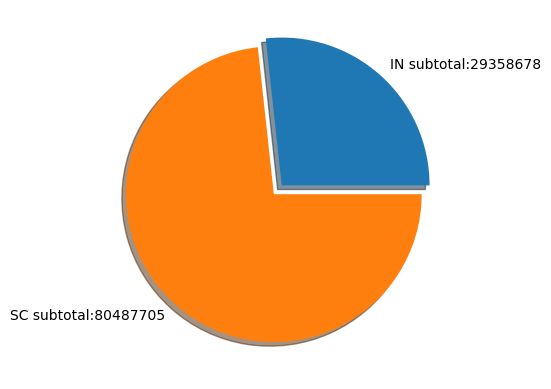

In [33]:
sumINköp = sum(dfINkunder["total"])#för totala köp alla ordrar för en köpare
sumSCköp = sum(dfSCkunder["total"])
pie = [sumINköp,sumSCköp]
plt.pie(pie,labels = ['IN subtotal:'+ str(math.ceil(sumINköp)),'SC subtotal:'+str(math.ceil(sumSCköp))],explode = [0.08,0], shadow = True)
plt.show() # största delen av intäkter är från SC kunder, troligen för dem köper större bulk
#ingen titel med vi sätter den nödvädning informationen vi labels "subtotal", för att spara utrymme.

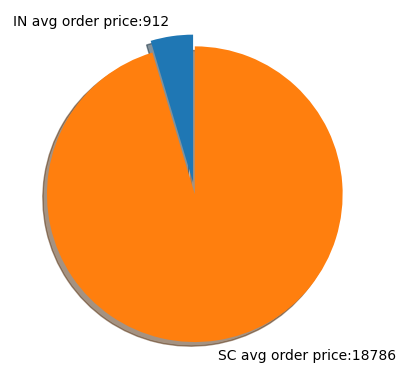

In [36]:
meanavgoforderSC = np.mean(dfSCkunder["AVGsubtotaloforders"])
meanavgoforderIN = np.mean(dfINkunder["AVGsubtotaloforders"])#avgsub... står för kundens mellanvärde i price per order
pie2 = [meanavgoforderIN,meanavgoforderSC]
plt.pie(pie2,labels = ['IN avg order price:'+ str(math.ceil(meanavgoforderIN)),'SC avg order price:'+str(math.ceil(meanavgoforderSC))],explode = [0.08,0], shadow = True, startangle= 90)
plt.show()
#np.mean(dfXkunder["AVGsubtotaloforders"]) = igenomsnitt spendering per order för alla kunder,
#med andra ord va en sc/in kunds order tenderar att vara mellan
#startangel argumentent är inte med i charten som finns i documentent därför ser den annorlunda ut.

In [37]:
countIN = dfköpdata.PersonType.value_counts().iloc[0] #18484 indv köpare
countSC = dfköpdata.PersonType.value_counts().iloc[1] #635 butiks köpare
print(sumSCköp/countSC,sumINköp/countIN)#medelvärde
#bara ett test behövdes ej längre

126752.29005228356 1588.3292155755412


In [38]:
kiallaSCkunder = stats.norm.interval(0.95, loc=np.mean(dfSCkunder["AVGsubtotaloforders"]), scale=stats.sem(dfSCkunder["AVGsubtotaloforders"]))
kiallaINkunder = stats.norm.interval(0.95, loc=np.mean(dfINkunder["AVGsubtotaloforders"]), scale=stats.sem(dfINkunder["AVGsubtotaloforders"]))
print("SC-kustomer CI för average order by customer")
print(kiallaSCkunder)
print("IN-customers CI för average order by customer")
print(kiallaINkunder)

SC-kustomer CI för average order by customer
(17008.89062639072, 20562.18587786125)
IN-customers CI för average order by customer
(896.859228611745, 926.8686739526349)


In [39]:
dfINkunder["Amount of orders"].value_counts()#ej med
#obs poängen överlag med detta var att jämnföra antal ordrar med andra, men vi har ej plats

1     11619
2      5454
3      1166
4       150
5        51
16       14
27       11
17        7
6         5
7         4
28        2
25        1
Name: Amount of orders, dtype: int64

<Axes: >

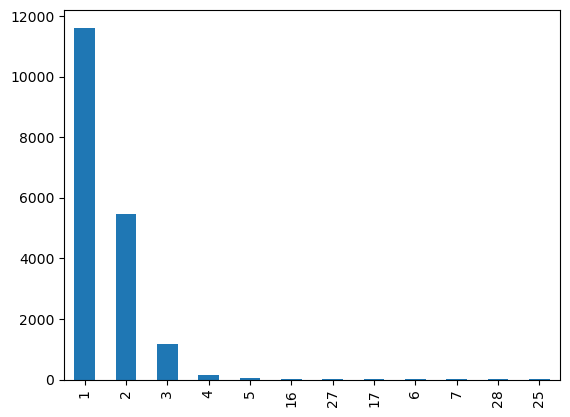

In [40]:
dfINkunder["Amount of orders"].value_counts().plot(kind="bar")#ej med
#Majoritete av köp är små köp av IN kunder

In [41]:
print(dfSCkunder["Amount of orders"].value_counts())#ej med

4     236
8     149
12     64
3      38
7      33
1      30
6      19
5      19
2      19
11     10
9      10
10      8
Name: Amount of orders, dtype: int64


<Axes: >

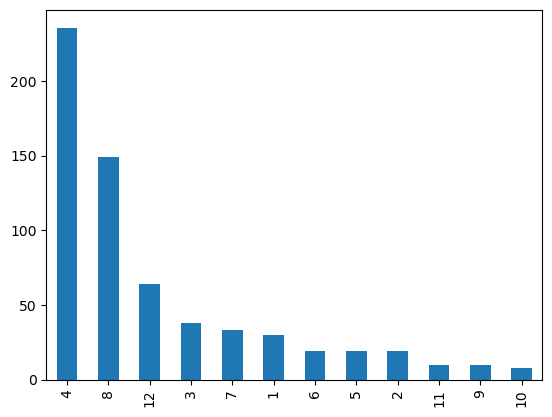

In [42]:
dfSCkunder["Amount of orders"].value_counts().plot(kind="bar")#ej med
#bättre distrubering men sjävklart gör SC kunder större ordrar normallt sätt

In [43]:
#sätt kriterier för att flagga kunder som stor handlare
#gärns på top 20 av total spent, igen separera IN och SC kunder
top20IN = dfINkunder.sort_values("total",ascending =False).head(20)
top20SC = dfSCkunder.sort_values("total",ascending =False).head(20)
#vårat kriterie kommer vara medelvärdet av top 20 total spent, averagetotalperorder
mean20IN = np.mean(top20IN["AVGsubtotaloforders"])
mean20SC = np.mean(top20SC["AVGsubtotaloforders"])
print(mean20IN,mean20SC)
#våra kriterier är nu suttna utifrån top spenderare men det kan finns kunder som 
#har nått upp till avgsubtotalperorder som inte är en top 20 spenderare, alltså flagga dem för potential

2402.298745 68756.366885


In [44]:
top20IN 

,CustomerID,total,Amount of orders,AVGsubtotaloforders,FirstName,LastName,PersonType,PersonID,StoreID,Name,SalesPersonID,SP First name,SP Last name
1301,12301,13295.3800,5,2659.0760,Nichole,Nara,IN,16617,None,None,None,None,None
1132,12132,13294.2700,5,2658.8540,Kaitlyn,Henderson,IN,20610,None,None,None,None,None
1308,12308,13269.2700,5,2653.8540,Margaret,He,IN,17731,None,None,None,None,None
1131,12131,13265.9900,5,2653.1980,Randall,Dominguez,IN,14974,None,None,None,None,None
1300,12300,13242.7000,5,2648.5400,Adriana,Gonzalez,IN,3189,None,None,None,None,None
1321,12321,13215.6500,5,2643.1300,Rosa,Hu,IN,4987,None,None,None,None,None
1124,12124,13195.6400,5,2639.1280,Brandi,Gill,IN,18487,None,None,None,None,None
1307,12307,13173.1900,5,2634.6380,Brad,She,IN,9369,None,None,None,None,None
1296,12296,13164.6400,5,2632.9280,Francisco,Sara,IN,16701,None,None,None,None,None
433,11433,12909.6682,6,2151.6113,Maurice,Shan,IN,9067,None,None,None,None,None


In [45]:
top20IN["Amount of orders"].value_counts()#ej med

5    9
4    5
7    4
6    2
Name: Amount of orders, dtype: int64

In [46]:
top20SC

,CustomerID,total,Amount of orders,AVGsubtotaloforders,FirstName,LastName,PersonType,PersonID,StoreID,Name,SalesPersonID,SP First name,SP Last name
334,29818,877107.1923,12,73092.2660,Roger,Harui,SC,1031,1032,Brakes and Gears,276,Linda,Mitchell
231,29715,853849.1795,12,71154.0982,Andrew,Dixon,SC,813,814,Excellent Riding Supplies,279,Tsvi,Reiter
238,29722,841908.7707,12,70159.0642,Reuben,D'sa,SC,827,828,Vigorous Exercise Company,282,José,Saraiva
633,30117,816755.5763,12,68062.9646,Robert,Vessa,SC,1991,1992,Totes & Baskets Company,277,Jillian,Carson
130,29614,799277.8950,12,66606.4912,Ryan,Calafato,SC,591,592,Retail Mall,282,José,Saraiva
155,29639,787773.0438,12,65647.7536,Joseph,Castellucio,SC,647,648,Corner Bicycle Supply,282,José,Saraiva
217,29701,746317.5293,8,93289.6911,Kirk,DeGrasse,SC,785,786,Outdoor Equipment Store,275,Michael,Blythe
133,29617,740985.8338,12,61748.8194,Lindsey,Camacho,SC,599,600,Thorough Parts and Repair Services,280,Pamela,Ansman-Wolfe
510,29994,730798.7139,12,60899.8928,Robin,McGuigan,SC,1417,1418,"Health Spa, Limited",282,José,Saraiva
162,29646,727272.6493,12,60606.0541,Stacey,Cereghino,SC,661,662,Fitness Toy Store,277,Jillian,Carson


In [47]:
top20SC["Amount of orders"].value_counts()#ej med

12    14
8      6
Name: Amount of orders, dtype: int64

In [48]:
Df_inom_krit_IN = dfINkunder[dfINkunder['AVGsubtotaloforders'] >= mean20IN]
Df_inom_krit_IN

,CustomerID,total,Amount of orders,AVGsubtotaloforders,FirstName,LastName,PersonType,PersonID,StoreID,Name,SalesPersonID,SP First name,SP Last name
0,11000,8248.99,3,2749.6633,Jon,Yang,IN,13531,None,None,None,None,None
2,11002,8114.04,3,2704.6800,Ruben,Torres,IN,11269,None,None,None,None,None
3,11003,8139.29,3,2713.0966,Christy,Zhu,IN,11358,None,None,None,None,None
4,11004,8196.01,3,2732.0033,Elizabeth,Johnson,IN,11901,None,None,None,None,None
5,11005,8121.33,3,2707.1100,Julio,Ruiz,IN,6990,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18475,29475,3399.99,1,3399.9900,Jared,Ward,IN,14291,None,None,None,None,None
18476,29476,3399.99,1,3399.9900,Elizabeth,Bradley,IN,12655,None,None,None,None,None
18477,29477,2428.05,1,2428.0500,Neil,Ruiz,IN,6836,None,None,None,None,None
18480,29480,2442.03,1,2442.0300,Nina,Raji,IN,4472,None,None,None,None,None


In [49]:
Df_inom_krit_SC = dfSCkunder[dfSCkunder['AVGsubtotaloforders'] >= mean20SC]
Df_inom_krit_SC

,CustomerID,total,Amount of orders,AVGsubtotaloforders,FirstName,LastName,PersonType,PersonID,StoreID,Name,SalesPersonID,SP First name,SP Last name
78,29562,585516.4328,8,73189.5541,Steven,Brown,SC,477,478,Golf and Cycle Store,281,Shu,Ito
80,29564,283745.8828,4,70936.4707,Mary,Billstrom,SC,481,482,Favorite Toy Distributor,290,Ranjit,Varkey Chudukatil
110,29594,357708.7747,4,89427.1936,Dave,Browning,SC,547,548,Eastside Sporting Goods,275,Michael,Blythe
131,29615,299985.1979,4,74996.2994,Mari,Caldwell,SC,595,596,Metro Metals Co.,289,Jae,Pak
132,29616,617340.4579,8,77167.5572,Barbara,Calone,SC,597,598,Sheet Metal Manufacturing,277,Jillian,Carson
140,29624,431991.5500,4,107997.8875,Joseph,Cantoni,SC,615,616,Tread Industries,279,Tsvi,Reiter
145,29629,343349.7833,4,85837.4458,Carlton,Carlisle,SC,625,626,Camping and Sports Store,282,José,Saraiva
157,29641,534956.2785,4,133739.0696,Raul,Casts,SC,651,652,Westside Plaza,281,Shu,Ito
217,29701,746317.5293,8,93289.6911,Kirk,DeGrasse,SC,785,786,Outdoor Equipment Store,275,Michael,Blythe
228,29712,580222.3284,8,72527.7910,Holly,Dickson,SC,807,808,Registered Cycle Store,290,Ranjit,Varkey Chudukatil


29 , 635 , 0.04566929133858268 andel som uppnår kriterier per PersonType
2029 , 18484 , 0.10977061242155378 andel som uppnår kriterier per PersonType


Text(0.5, 1.0, 'Uppdelade andelar')

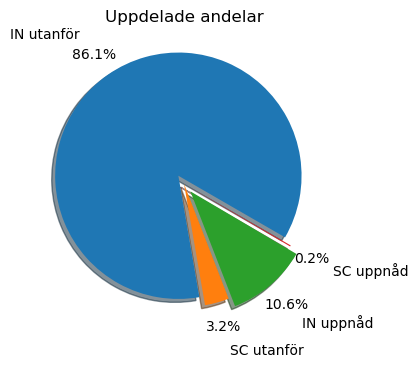

In [66]:
print(len(Df_inom_krit_SC),",",len(dfSCkunder),",",len(Df_inom_krit_SC)/len(dfSCkunder),"andel som uppnår kriterier per PersonType")
print(len(Df_inom_krit_IN),",",len(dfINkunder),",",len(Df_inom_krit_IN)/len(dfINkunder),"andel som uppnår kriterier per PersonType")
df_utanför_krit_IN = dfINkunder[dfINkunder['AVGsubtotaloforders'] < mean20IN]
df_utanför_krit_SC = dfSCkunder[dfSCkunder['AVGsubtotaloforders'] < mean20SC]
piecompare = [len(df_utanför_krit_IN),len(df_utanför_krit_SC),len(Df_inom_krit_IN),len(Df_inom_krit_SC)]
fig, ax = plt.subplots(figsize = (7,4))
ax.pie(piecompare,labels =["IN utanför","SC utanför","IN uppnåd","SC uppnåd"],explode = [0.08,0,0.08,0], shadow = True, autopct='%1.1f%%',
       pctdistance=1.2, labeldistance=1.4,  startangle= 330)
ax.set_title("Uppdelade andelar")
# väldigt liten andel uppnår våra kriterier
# totalt sätt utav


Text(0.5, 1.0, 'IN Kunder total spent')

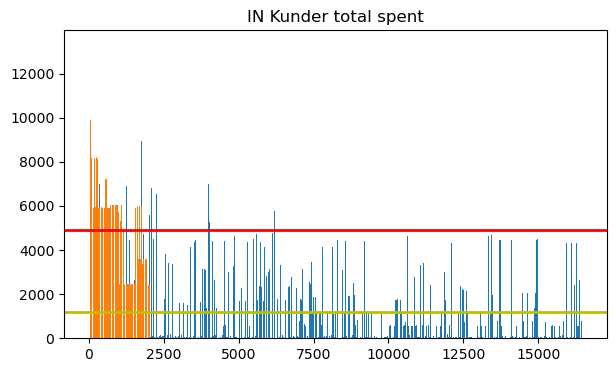

In [52]:
fig, ax = plt.subplots(figsize = (7,4))
lendf_utanför_krit_IN = np.arange(len(df_utanför_krit_IN))
lenDf_inom_krit_IN = np.arange(len(Df_inom_krit_IN))
ax.bar(lendf_utanför_krit_IN,df_utanför_krit_IN["total"])
ax.bar(lenDf_inom_krit_IN,Df_inom_krit_IN["total"])
ax.axhline(np.mean(Df_inom_krit_IN["total"]), color = 'r',linewidth=2)
ax.axhline(np.mean(df_utanför_krit_IN["total"]), color = 'y',linewidth=2)
ax.set_title("IN Kunder total spent")

Text(0.5, 1.0, 'SC Kunder total spent')

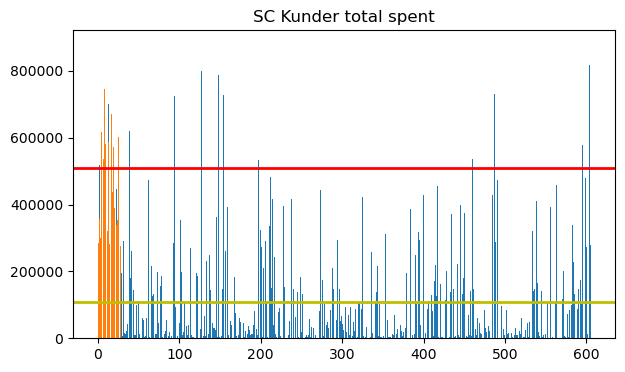

In [53]:
fig, ax = plt.subplots(figsize = (7,4))
lendf_utanför_krit_SC = np.arange(len(df_utanför_krit_SC))
lenDf_inom_krit_SC = np.arange(len(Df_inom_krit_SC))
ax.bar(lendf_utanför_krit_SC,df_utanför_krit_SC["total"])
ax.bar(lenDf_inom_krit_SC,Df_inom_krit_SC["total"])
ax.axhline(np.mean(Df_inom_krit_SC["total"]), color = 'r',linewidth=2)
ax.axhline(np.mean(df_utanför_krit_SC["total"]), color = 'y',linewidth=2)
ax.set_title("SC Kunder total spent")

In [54]:
print(len(dfköpdata),(len(Df_inom_krit_SC)+len(Df_inom_krit_IN)))
print((len(Df_inom_krit_SC)+len(Df_inom_krit_IN))/len(dfköpdata))
print("cirkus 11% av alla kunder uppnår våra krav ")

19119 2058
0.10764161305507611
cirkus 10% av alla kunder uppnår våra krav 


19384400.908200003
9974276.3125
65696243.321499996
14791460.8617


Text(0.5, 1.0, 'Total spent')

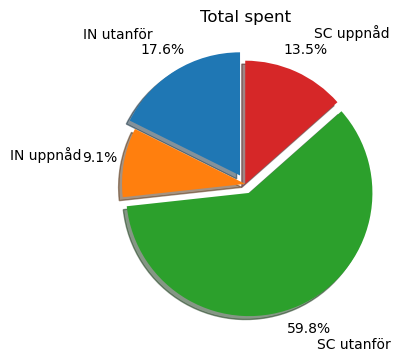

In [56]:
print(df_utanför_krit_IN["total"].sum())
print(Df_inom_krit_IN["total"].sum())
print(df_utanför_krit_SC["total"].sum())
print(Df_inom_krit_SC["total"].sum())
sumcomparison= [df_utanför_krit_IN["total"].sum(),Df_inom_krit_IN["total"].sum(),df_utanför_krit_SC["total"].sum(),Df_inom_krit_SC["total"].sum()]
fig, ax = plt.subplots(figsize = (7,4))
ax.pie(sumcomparison,labels =["IN utanför","IN uppnåd","SC utanför","SC uppnåd"],explode = [0.08,0,0.08,0], shadow = True, autopct='%1.1f%%'
        ,pctdistance=1.2, labeldistance=1.35, startangle= 90)
ax.set_title("Total spent")

In [60]:
(sumcomparison[1]+sumcomparison[3])
print((sumcomparison[1]+sumcomparison[3])/sum(sumcomparison))

0.22545792458230865


In [65]:
#OBS eftersom n<30 hos våra SC kunder så måste vi använda en T fördelnings beräkning istället
#n<30 så t fördelnings ist fg = n-1
Ki_inom_krit_SC = stats.t.interval(0.95,df=len(Df_inom_krit_SC)-1, loc=np.mean(Df_inom_krit_SC["total"]), scale=stats.sem(Df_inom_krit_SC["total"]))
Ki_inom_krit_IN = stats.norm.interval(0.95, loc=np.mean(Df_inom_krit_IN["total"]), scale=stats.sem(Df_inom_krit_IN["total"]))
print(Ki_inom_krit_SC)
print(Ki_inom_krit_IN)''
# här kan vi kan se att dem som är flaggade som stor spenderare kommer med 95% konfidens 
#ha spenderat totalt mellan (443936.09842726274, 576164.6506554959) normalfördelad
#(4828.854655772928, 5002.861768574041) IN kunder
#
print("SC-inomKrit-customers, KI för Total spent")
print(Ki_inom_krit_SC)
print("IN-inomKrit-customers, KI för Total spent")
print(Ki_inom_krit_IN)



(440952.69905600033, 579148.0500267583)
(4828.854655772928, 5002.861768574041)
SC-inomKrit-customers, KI för Total spent
(440952.69905600033, 579148.0500267583)
IN-inomKrit-customers, KI för Total spent
(4828.854655772928, 5002.861768574041)


In [62]:
#test med normalfKI
stats.norm.interval(0.95, loc=np.mean(Df_inom_krit_SC["total"]), scale=stats.sem(Df_inom_krit_SC["total"]))


(443936.09842726274, 576164.6506554959)